<a href="https://colab.research.google.com/github/sbalram123/CoronaBatch-Session4/blob/master/SB_CoronaBatch_A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Take the 5th code from assignment 4 .
#run your model for 25 epochs for each:
# without L1/L2 with BN
# without L1/L2 with GBN
# with L1 with BN
# with L1 with GBN
# with L2 with BN
# with L2 with GBN
# with L1 and L2 with BN
# with L1 and L2 with GBN
# You cannot be running your code 8 times manually (-500 points for that). You need to be smarter and write a single loop or iterator to iterate through these conditions. 
# draw ONE graph to show the validation accuracy curves for all 8 jobs above. This graph must have proper legends and it should be clear what we are looking at. 
# draw ONE graph to show the loss change curves for all 8 jobs above. This graph must have proper legends and it should be clear what we are looking at. 
# find any 25 misclassified images for "without L1/L2 with BN" AND "without L1/L2 with GBN" model. You should be using the saved model from the above jobs. 
# and L2 models. You MUST show the actual and predicted class names.
# make all the images available on Github Readme page, so you can upload the images for your assignment (you can upload them somewhere else as well for add image url).
# submit the Github link for your notebook with logs, and also upload the images in the S6-Assignment Solution. 

In [0]:
# The gods
from __future__ import print_function
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pdb # Python Debugger Lib
from itertools import chain
from inspect import signature
from functools import lru_cache as cache
from collections import defaultdict, namedtuple


In [0]:
class TrainTestUtils(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []
        self.misclassifiedImages = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = TrainTestUtils.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations normal
        train_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms


    def get_train_transforms_rotaion(mean=0.1307, std=0.3081):
        # Train Phase transformations with rotation
        train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.2, 6.2), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean,), (std,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])
        return train_transforms


    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std


    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = TrainTestUtils.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = TrainTestUtils.get_train_transforms_rotaion()
        if test_transforms is None:
            test_transforms = TrainTestUtils.get_test_transforms()
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    
    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch, l1_factor=None):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        #pdb.set_trace()
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #update l1 regularizer if requested
        if l1_factor:
          loss = self.apply_l1_regularizer(loss, model, l1_factor)

        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        self.misclassifiedImages = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                target_change = target.view_as(pred)
                for i in range(len(pred)):
                  if pred[i].item()!= target_change[i].item():
                    self.misclassifiedImages.append([data[i], pred[i], target_change[i]])
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)
        print("Number of miscalssified Images = ",len(self.misclassifiedImages))

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))



    def train_test_model(self, model, EPOCHS=25, batch_size=128, path='./data', optimizer=None, train_transforms=None, test_transforms=None, l1_factor=None):
        # Train and test our model
        if optimizer is None:
            optimizer = self.get_optimizer(model, lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path, train_transforms=train_transforms, test_transforms=test_transforms)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch, l1_factor=l1_factor)
            self.test(model, device, test_loader)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff


    def get_optimizer(self, model, lr=0.01, momentum=0.9):
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        return optimizer

    def get_step_optimizer(self, model, lr=0.01, momentum=0.9, step_size=1, gamma=0.1):
       optimizer = self.get_optimizer(model, lr, momentum)
       scheduler = StepLR(optimizer, step_size, gamma)
       return optimizer

    def apply_l1_regularizer(self, loss, model, l1_factor=0.00008):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        parameters = model.parameters()
        for param in parameters:
          reg_loss += torch.sum(param.abs())
          # zero_vector = torch.rand_like(param) * 0
          # reg_loss += l1_crit(param, zero_vector)
        loss += l1_factor * reg_loss
        return loss

    def apply_l2_regularizer(self, model, weight_decay, lr=0.01, momentum=0.9):
        l2_regularizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        return l2_regularizer

    
    def plot_misclassified(self, misclassifiedImages):
      fig = plt.figure(figsize = (10,10))
      for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassifiedImages[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        sub.set_title("Pred={}, Act={}".format(str(misclassifiedImages[i][1].data.cpu().numpy()),str(misclassifiedImages[i][2].data.cpu().numpy())))       
      plt.tight_layout()
      plt.show()

    def plot_test_loss_acc(self,test_losses,test_acc):
      fig, axs = plt.subplots(1,2,figsize=(15,10))
      axs[0].plot(test_losses)
      axs[0].set_title("Test Loss")
      axs[1].plot(test_acc)
      axs[1].set_title("Test Accuracy")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            pass

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
def norm2d(output_channels, batch_type="BN"):
    if batch_type == "GBN":
        num_splits = 2
        return GhostBatchNorm(output_channels,num_splits)
    else:
        return nn.BatchNorm2d(output_channels)

In [0]:
dropout = 0.09
class Net(nn.Module):
    def __init__(self, batch_type="BN"):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 10, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(10),
                                   norm2d(10, batch_type),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(10, 20, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(20),
                                   norm2d(20, batch_type),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(20, 10, 1,bias=False),

                                   nn.MaxPool2d(2, 2),

                                   nn.Conv2d(10, 20, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(20),
                                   norm2d(20, batch_type),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(20, 16, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(16),
                                   norm2d(16, batch_type),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(16, 10, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(10),
                                   norm2d(10, batch_type),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(10, 16, 3,padding =1,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(16),
                                   norm2d(16, batch_type),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.AvgPool2d(kernel_size=6),
                                   nn.Conv2d(16, 10, 1,bias=False))

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
#BN WITHOUT L1L2 initialized
bn_test_without_L1L2_Loss = []
bn_test_without_L1L2_acc = []
bn_misclassifiedwithoutL1L2= []

#BN WITH L1 initialized
bn_test_with_L1_Loss = []
bn_test_with_L1_acc = []
bn_misclassifiedL1 = []

#BN WITH L2 initialized
bn_test_with_L2_Loss = []
bn_test_with_L2_acc = []
bn_misclassifiedL2 = []

#BN WITH L1L2 initialized
bn_test_with_L1L2_Loss = []
bn_test_with_L1L2_acc = []
bn_misclassifiedL1L2 = []

#GBN WITHOUT L1L2 initialized
gbn_test_without_L1L2_Loss = []
gbn_test_without_L1L2_acc = []
gbn_misclassifiedwithoutL1L2 = []

#GBN WITH L1 initialized
gbn_test_with_L1_Loss = []
gbn_test_with_L1_acc = []
gbn_misclassifiedL1 = []

#GBN WITH L2 initialized
gbn_test_with_L2_Loss = []
gbn_test_with_L2_acc = []
gbn_misclassifiedL2 = []

#GBN WITH L1L2 initialized
gbn_test_with_L1L2_Loss = []
gbn_test_with_L1L2_acc = []
gbn_misclassifiedL1L2 = []

EPOCHS = 25
GBN_BATCHSIZE = 64
BN_BATCHSIZE = 32

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.4428822994232178 Batch_id=937 Accuracy=86.36: 100%|██████████| 938/938 [00:16<00:00, 55.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  162

Test set: Average loss: 0.0589, Accuracy: 9838/10000 (98.38%)

EPOCH: 2


Train Set: Train Loss=0.20686332881450653 Batch_id=937 Accuracy=95.65: 100%|██████████| 938/938 [00:17<00:00, 53.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0440, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Train Set: Train Loss=0.04850099980831146 Batch_id=937 Accuracy=96.49: 100%|██████████| 938/938 [00:17<00:00, 54.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  91

Test set: Average loss: 0.0314, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Train Set: Train Loss=0.0329175740480423 Batch_id=937 Accuracy=96.81: 100%|██████████| 938/938 [00:16<00:00, 55.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  100

Test set: Average loss: 0.0324, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Train Set: Train Loss=0.1852874755859375 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [00:17<00:00, 54.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  88

Test set: Average loss: 0.0275, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Train Set: Train Loss=0.07849838584661484 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:17<00:00, 54.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  76

Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Train Set: Train Loss=0.20215485990047455 Batch_id=937 Accuracy=97.41: 100%|██████████| 938/938 [00:16<00:00, 55.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  81

Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Train Set: Train Loss=0.08621110767126083 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:16<00:00, 55.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  77

Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Train Set: Train Loss=0.05741438269615173 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:16<00:00, 55.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  82

Test set: Average loss: 0.0241, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Train Set: Train Loss=0.10964255779981613 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:16<00:00, 55.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Train Set: Train Loss=0.01784445345401764 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:16<00:00, 55.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Train Set: Train Loss=0.04398375749588013 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:17<00:00, 54.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  74

Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Train Set: Train Loss=0.020463839173316956 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:17<00:00, 53.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Train Set: Train Loss=0.37390971183776855 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:17<00:00, 55.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Train Set: Train Loss=0.19491572678089142 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:17<00:00, 54.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Train Set: Train Loss=0.027498453855514526 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:16<00:00, 55.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  59

Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Train Set: Train Loss=0.08309030532836914 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:17<00:00, 54.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Train Set: Train Loss=0.044963300228118896 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [00:17<00:00, 54.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  58

Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Train Set: Train Loss=0.005040451884269714 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:17<00:00, 54.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Train Set: Train Loss=0.06120525673031807 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:17<00:00, 53.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Train Set: Train Loss=0.025510266423225403 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:17<00:00, 53.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  59

Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Train Set: Train Loss=0.002868950366973877 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:17<00:00, 54.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  67

Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Train Set: Train Loss=0.10703514516353607 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:17<00:00, 53.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  63

Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Train Set: Train Loss=0.030848786234855652 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:16<00:00, 55.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  60

Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Train Set: Train Loss=0.12449747323989868 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:17<00:00, 54.60it/s]


Number of miscalssified Images =  64

Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)



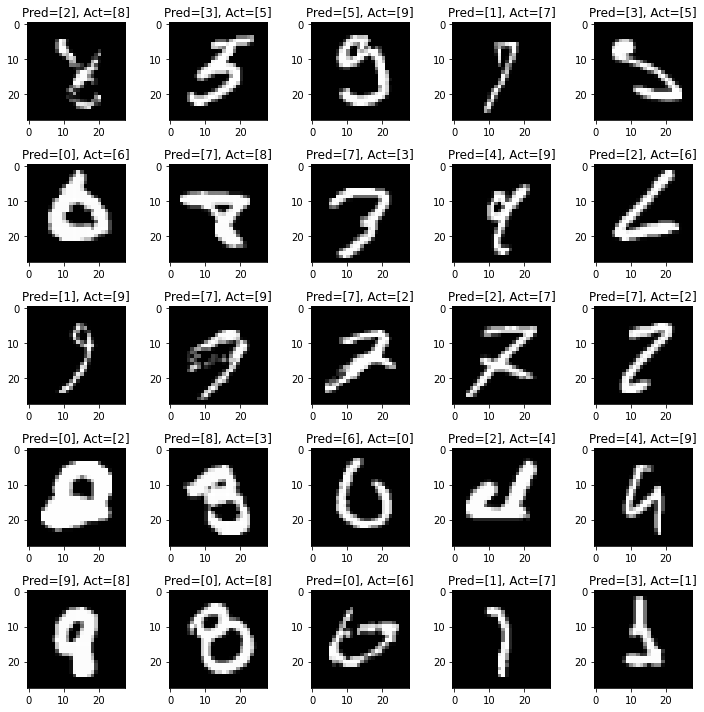

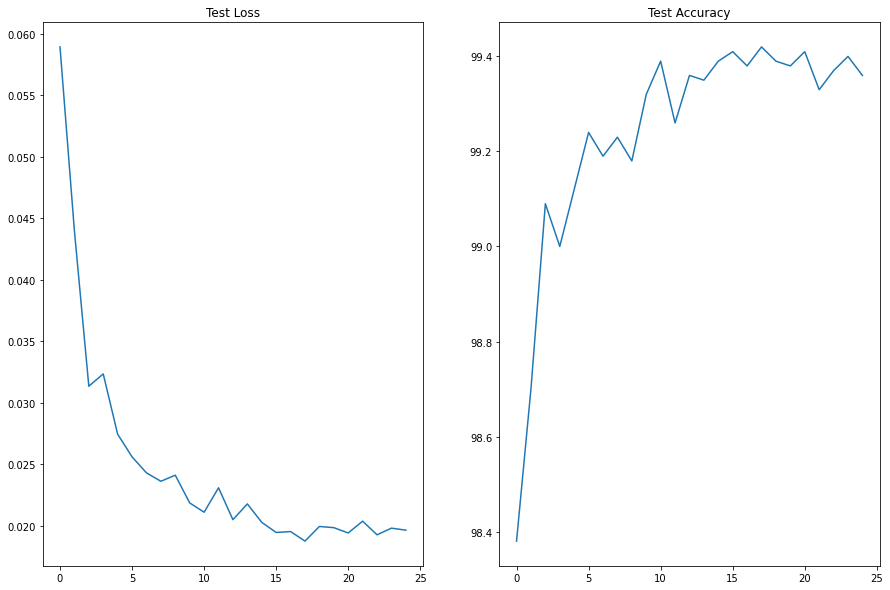

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE)

    gbn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_without_L1L2_Loss, gbn_test_without_L1L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.5893402695655823 Batch_id=937 Accuracy=85.09: 100%|██████████| 938/938 [00:19<00:00, 48.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  204

Test set: Average loss: 0.0710, Accuracy: 9796/10000 (97.96%)

EPOCH: 2


Train Set: Train Loss=0.36397725343704224 Batch_id=937 Accuracy=94.85: 100%|██████████| 938/938 [00:19<00:00, 48.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  162

Test set: Average loss: 0.0542, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


Train Set: Train Loss=0.3438760042190552 Batch_id=937 Accuracy=95.58: 100%|██████████| 938/938 [00:19<00:00, 47.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  148

Test set: Average loss: 0.0496, Accuracy: 9852/10000 (98.52%)

EPOCH: 4


Train Set: Train Loss=0.41244322061538696 Batch_id=937 Accuracy=95.75: 100%|██████████| 938/938 [00:19<00:00, 48.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  161

Test set: Average loss: 0.0521, Accuracy: 9839/10000 (98.39%)

EPOCH: 5


Train Set: Train Loss=0.3894093334674835 Batch_id=937 Accuracy=96.11: 100%|██████████| 938/938 [00:18<00:00, 49.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  106

Test set: Average loss: 0.0368, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Train Set: Train Loss=0.39356571435928345 Batch_id=937 Accuracy=96.10: 100%|██████████| 938/938 [00:18<00:00, 49.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  144

Test set: Average loss: 0.0480, Accuracy: 9856/10000 (98.56%)

EPOCH: 7


Train Set: Train Loss=0.5475058555603027 Batch_id=937 Accuracy=96.30: 100%|██████████| 938/938 [00:18<00:00, 49.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  128

Test set: Average loss: 0.0410, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Train Set: Train Loss=0.3323594629764557 Batch_id=937 Accuracy=96.20: 100%|██████████| 938/938 [00:18<00:00, 49.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0418, Accuracy: 9866/10000 (98.66%)

EPOCH: 9


Train Set: Train Loss=0.28050553798675537 Batch_id=937 Accuracy=96.36: 100%|██████████| 938/938 [00:18<00:00, 49.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  131

Test set: Average loss: 0.0452, Accuracy: 9869/10000 (98.69%)

EPOCH: 10


Train Set: Train Loss=0.4294925332069397 Batch_id=937 Accuracy=96.32: 100%|██████████| 938/938 [00:19<00:00, 49.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  112

Test set: Average loss: 0.0361, Accuracy: 9888/10000 (98.88%)

EPOCH: 11


Train Set: Train Loss=0.403035044670105 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:18<00:00, 49.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  146

Test set: Average loss: 0.0501, Accuracy: 9854/10000 (98.54%)

EPOCH: 12


Train Set: Train Loss=0.4404771029949188 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:18<00:00, 50.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0410, Accuracy: 9870/10000 (98.70%)

EPOCH: 13


Train Set: Train Loss=0.31877318024635315 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:19<00:00, 49.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  150

Test set: Average loss: 0.0436, Accuracy: 9850/10000 (98.50%)

EPOCH: 14


Train Set: Train Loss=0.749250054359436 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:19<00:00, 48.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  136

Test set: Average loss: 0.0393, Accuracy: 9864/10000 (98.64%)

EPOCH: 15


Train Set: Train Loss=0.48250091075897217 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:19<00:00, 48.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  125

Test set: Average loss: 0.0406, Accuracy: 9875/10000 (98.75%)

EPOCH: 16


Train Set: Train Loss=0.381168007850647 Batch_id=937 Accuracy=96.48: 100%|██████████| 938/938 [00:19<00:00, 48.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  99

Test set: Average loss: 0.0373, Accuracy: 9901/10000 (99.01%)

EPOCH: 17


Train Set: Train Loss=0.4019564390182495 Batch_id=937 Accuracy=96.51: 100%|██████████| 938/938 [00:19<00:00, 48.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0403, Accuracy: 9873/10000 (98.73%)

EPOCH: 18


Train Set: Train Loss=0.39111801981925964 Batch_id=937 Accuracy=96.57: 100%|██████████| 938/938 [00:19<00:00, 48.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  115

Test set: Average loss: 0.0360, Accuracy: 9885/10000 (98.85%)

EPOCH: 19


Train Set: Train Loss=0.2596619725227356 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:19<00:00, 48.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  129

Test set: Average loss: 0.0401, Accuracy: 9871/10000 (98.71%)

EPOCH: 20


Train Set: Train Loss=0.2628372609615326 Batch_id=937 Accuracy=96.49: 100%|██████████| 938/938 [00:18<00:00, 49.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  161

Test set: Average loss: 0.0470, Accuracy: 9839/10000 (98.39%)

EPOCH: 21


Train Set: Train Loss=0.3115587532520294 Batch_id=937 Accuracy=96.39: 100%|██████████| 938/938 [00:19<00:00, 48.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  133

Test set: Average loss: 0.0411, Accuracy: 9867/10000 (98.67%)

EPOCH: 22


Train Set: Train Loss=0.22954455018043518 Batch_id=937 Accuracy=96.67: 100%|██████████| 938/938 [00:18<00:00, 50.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0391, Accuracy: 9873/10000 (98.73%)

EPOCH: 23


Train Set: Train Loss=0.32257357239723206 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:19<00:00, 48.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  120

Test set: Average loss: 0.0410, Accuracy: 9880/10000 (98.80%)

EPOCH: 24


Train Set: Train Loss=0.45897889137268066 Batch_id=937 Accuracy=96.52: 100%|██████████| 938/938 [00:19<00:00, 48.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  125

Test set: Average loss: 0.0407, Accuracy: 9875/10000 (98.75%)

EPOCH: 25


Train Set: Train Loss=0.5251080989837646 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:19<00:00, 49.12it/s]


Number of miscalssified Images =  133

Test set: Average loss: 0.0422, Accuracy: 9867/10000 (98.67%)



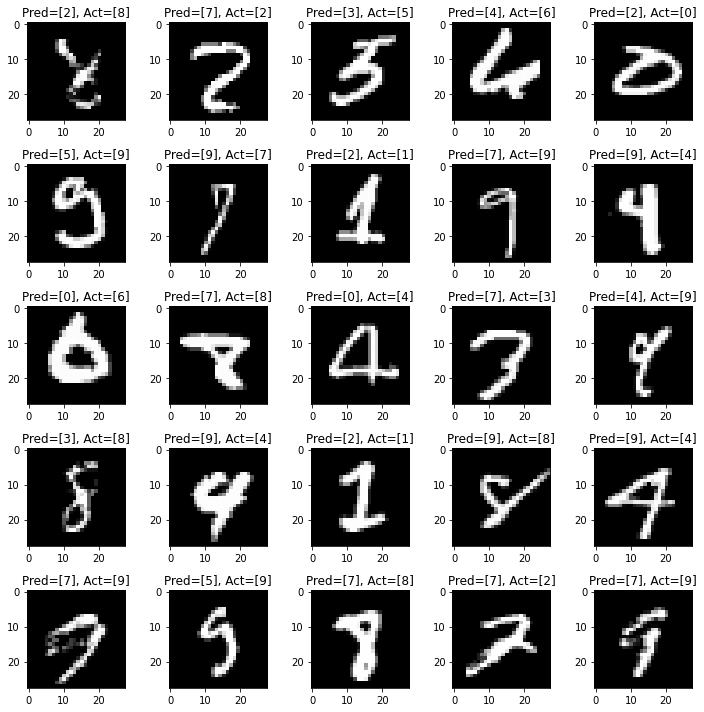

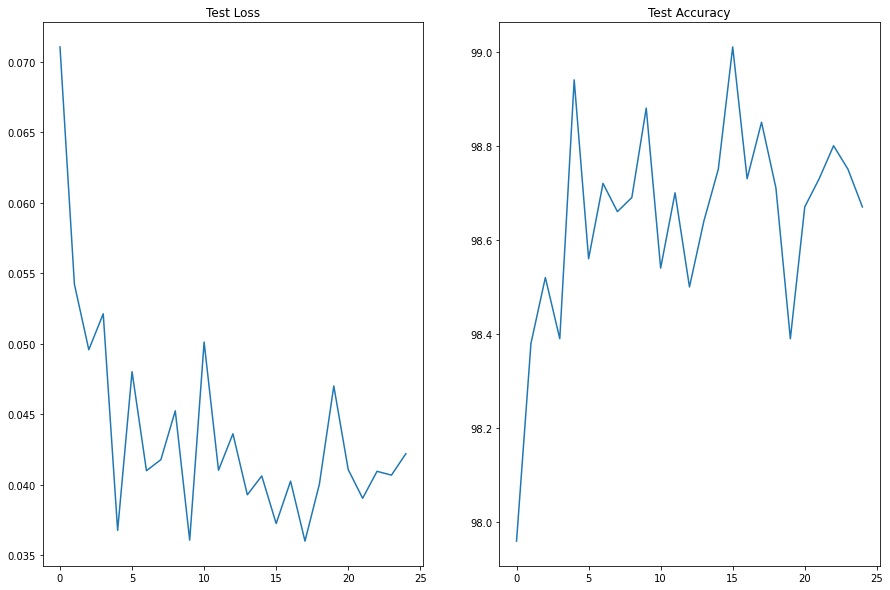

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005)

    gbn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL1)

    gbn_test_with_L1_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1_Loss, gbn_test_with_L1_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.2466886043548584 Batch_id=937 Accuracy=85.00: 100%|██████████| 938/938 [00:17<00:00, 52.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  205

Test set: Average loss: 0.0798, Accuracy: 9795/10000 (97.95%)

EPOCH: 2


Train Set: Train Loss=0.114942267537117 Batch_id=937 Accuracy=95.04: 100%|██████████| 938/938 [00:17<00:00, 52.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  196

Test set: Average loss: 0.0699, Accuracy: 9804/10000 (98.04%)

EPOCH: 3


Train Set: Train Loss=0.09723187237977982 Batch_id=937 Accuracy=95.62: 100%|██████████| 938/938 [00:17<00:00, 53.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  136

Test set: Average loss: 0.0582, Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Train Set: Train Loss=0.08673939108848572 Batch_id=937 Accuracy=95.83: 100%|██████████| 938/938 [00:17<00:00, 54.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  186

Test set: Average loss: 0.0693, Accuracy: 9814/10000 (98.14%)

EPOCH: 5


Train Set: Train Loss=0.1820569485425949 Batch_id=937 Accuracy=95.98: 100%|██████████| 938/938 [00:17<00:00, 54.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  122

Test set: Average loss: 0.0504, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Train Set: Train Loss=0.17668886482715607 Batch_id=937 Accuracy=96.04: 100%|██████████| 938/938 [00:17<00:00, 53.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0526, Accuracy: 9866/10000 (98.66%)

EPOCH: 7


Train Set: Train Loss=0.27843135595321655 Batch_id=937 Accuracy=96.24: 100%|██████████| 938/938 [00:17<00:00, 53.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0533, Accuracy: 9873/10000 (98.73%)

EPOCH: 8


Train Set: Train Loss=0.2884395718574524 Batch_id=937 Accuracy=96.12: 100%|██████████| 938/938 [00:17<00:00, 54.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  144

Test set: Average loss: 0.0575, Accuracy: 9856/10000 (98.56%)

EPOCH: 9


Train Set: Train Loss=0.1347353756427765 Batch_id=937 Accuracy=96.17: 100%|██████████| 938/938 [00:17<00:00, 53.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  133

Test set: Average loss: 0.0582, Accuracy: 9867/10000 (98.67%)

EPOCH: 10


Train Set: Train Loss=0.11851523816585541 Batch_id=937 Accuracy=96.22: 100%|██████████| 938/938 [00:16<00:00, 55.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  164

Test set: Average loss: 0.0662, Accuracy: 9836/10000 (98.36%)

EPOCH: 11


Train Set: Train Loss=0.13633601367473602 Batch_id=937 Accuracy=96.22: 100%|██████████| 938/938 [00:17<00:00, 55.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  142

Test set: Average loss: 0.0570, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Train Set: Train Loss=0.2822100520133972 Batch_id=937 Accuracy=96.34: 100%|██████████| 938/938 [00:17<00:00, 53.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  122

Test set: Average loss: 0.0473, Accuracy: 9878/10000 (98.78%)

EPOCH: 13


Train Set: Train Loss=0.09073901921510696 Batch_id=937 Accuracy=96.39: 100%|██████████| 938/938 [00:17<00:00, 54.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  155

Test set: Average loss: 0.0582, Accuracy: 9845/10000 (98.45%)

EPOCH: 14


Train Set: Train Loss=0.507264256477356 Batch_id=937 Accuracy=96.23: 100%|██████████| 938/938 [00:17<00:00, 54.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  155

Test set: Average loss: 0.0584, Accuracy: 9845/10000 (98.45%)

EPOCH: 15


Train Set: Train Loss=0.15522992610931396 Batch_id=937 Accuracy=96.34: 100%|██████████| 938/938 [00:17<00:00, 54.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  118

Test set: Average loss: 0.0469, Accuracy: 9882/10000 (98.82%)

EPOCH: 16


Train Set: Train Loss=0.14459100365638733 Batch_id=937 Accuracy=96.40: 100%|██████████| 938/938 [00:17<00:00, 54.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  107

Test set: Average loss: 0.0436, Accuracy: 9893/10000 (98.93%)

EPOCH: 17


Train Set: Train Loss=0.17606356739997864 Batch_id=937 Accuracy=96.35: 100%|██████████| 938/938 [00:17<00:00, 54.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  106

Test set: Average loss: 0.0443, Accuracy: 9894/10000 (98.94%)

EPOCH: 18


Train Set: Train Loss=0.1048944890499115 Batch_id=937 Accuracy=96.32: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  147

Test set: Average loss: 0.0566, Accuracy: 9853/10000 (98.53%)

EPOCH: 19


Train Set: Train Loss=0.0935036763548851 Batch_id=937 Accuracy=96.29: 100%|██████████| 938/938 [00:17<00:00, 54.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  168

Test set: Average loss: 0.0648, Accuracy: 9832/10000 (98.32%)

EPOCH: 20


Train Set: Train Loss=0.20449742674827576 Batch_id=937 Accuracy=96.28: 100%|██████████| 938/938 [00:17<00:00, 53.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  126

Test set: Average loss: 0.0503, Accuracy: 9874/10000 (98.74%)

EPOCH: 21


Train Set: Train Loss=0.14627231657505035 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:17<00:00, 54.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  125

Test set: Average loss: 0.0480, Accuracy: 9875/10000 (98.75%)

EPOCH: 22


Train Set: Train Loss=0.10427659004926682 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:17<00:00, 54.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0482, Accuracy: 9873/10000 (98.73%)

EPOCH: 23


Train Set: Train Loss=0.22470837831497192 Batch_id=937 Accuracy=96.47: 100%|██████████| 938/938 [00:18<00:00, 51.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  137

Test set: Average loss: 0.0563, Accuracy: 9863/10000 (98.63%)

EPOCH: 24


Train Set: Train Loss=0.16047173738479614 Batch_id=937 Accuracy=96.39: 100%|██████████| 938/938 [00:17<00:00, 54.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  140

Test set: Average loss: 0.0563, Accuracy: 9860/10000 (98.60%)

EPOCH: 25


Train Set: Train Loss=0.21113048493862152 Batch_id=937 Accuracy=96.30: 100%|██████████| 938/938 [00:17<00:00, 52.36it/s]


Number of miscalssified Images =  134

Test set: Average loss: 0.0556, Accuracy: 9866/10000 (98.66%)



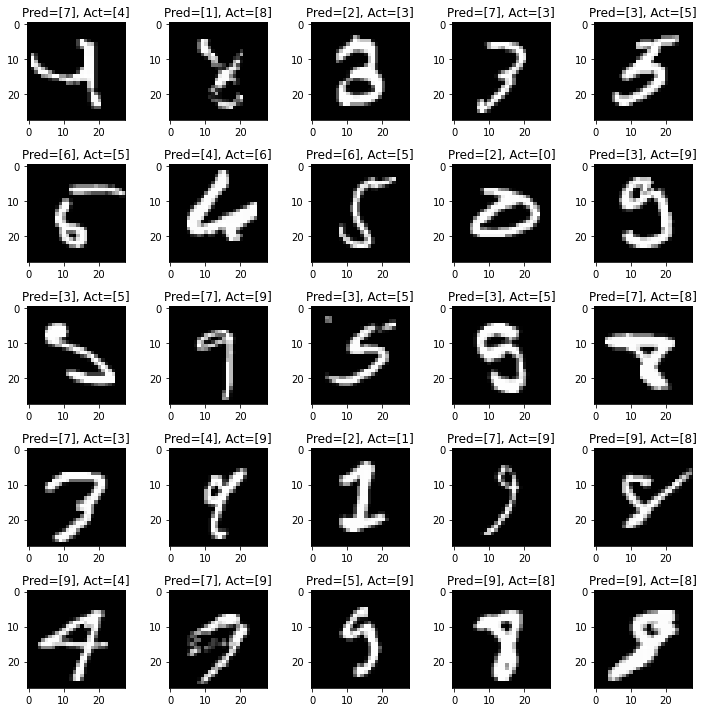

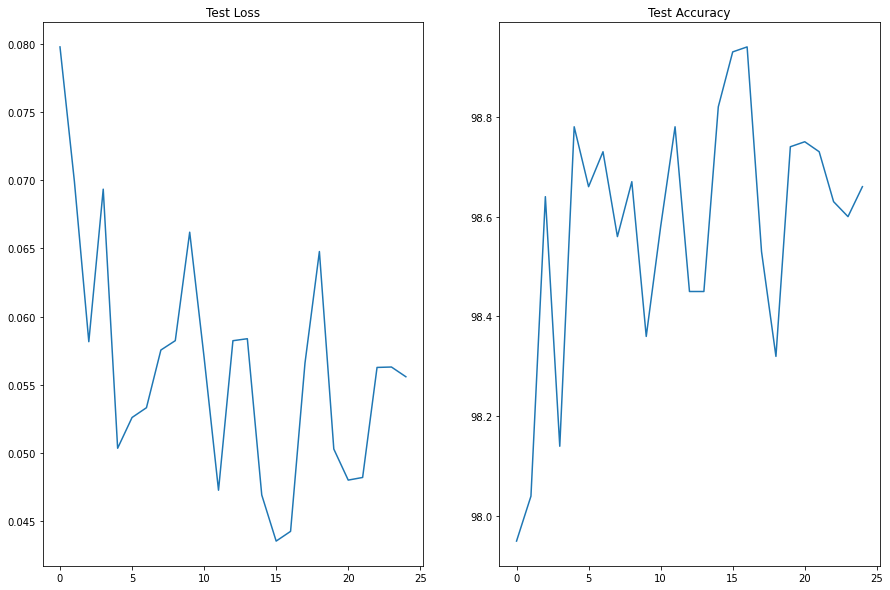

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, optimizer=l2_regulizer)

    gbn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL2)

    gbn_test_with_L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L2_Loss, gbn_test_with_L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.4851897358894348 Batch_id=937 Accuracy=84.86: 100%|██████████| 938/938 [00:19<00:00, 48.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  239

Test set: Average loss: 0.0914, Accuracy: 9761/10000 (97.61%)

EPOCH: 2


Train Set: Train Loss=0.491244375705719 Batch_id=937 Accuracy=94.19: 100%|██████████| 938/938 [00:19<00:00, 47.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  203

Test set: Average loss: 0.0787, Accuracy: 9797/10000 (97.97%)

EPOCH: 3


Train Set: Train Loss=0.296456903219223 Batch_id=937 Accuracy=94.72: 100%|██████████| 938/938 [00:19<00:00, 48.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  164

Test set: Average loss: 0.0735, Accuracy: 9836/10000 (98.36%)

EPOCH: 4


Train Set: Train Loss=0.37077200412750244 Batch_id=937 Accuracy=94.56: 100%|██████████| 938/938 [00:19<00:00, 48.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  208

Test set: Average loss: 0.0783, Accuracy: 9792/10000 (97.92%)

EPOCH: 5


Train Set: Train Loss=0.3961776793003082 Batch_id=937 Accuracy=94.96: 100%|██████████| 938/938 [00:19<00:00, 47.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  171

Test set: Average loss: 0.0671, Accuracy: 9829/10000 (98.29%)

EPOCH: 6


Train Set: Train Loss=0.29053932428359985 Batch_id=937 Accuracy=94.99: 100%|██████████| 938/938 [00:19<00:00, 47.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  188

Test set: Average loss: 0.0691, Accuracy: 9812/10000 (98.12%)

EPOCH: 7


Train Set: Train Loss=0.6550341844558716 Batch_id=937 Accuracy=95.02: 100%|██████████| 938/938 [00:19<00:00, 48.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  203

Test set: Average loss: 0.0829, Accuracy: 9797/10000 (97.97%)

EPOCH: 8


Train Set: Train Loss=0.4452075660228729 Batch_id=937 Accuracy=95.12: 100%|██████████| 938/938 [00:19<00:00, 48.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  220

Test set: Average loss: 0.0865, Accuracy: 9780/10000 (97.80%)

EPOCH: 9


Train Set: Train Loss=0.353201299905777 Batch_id=937 Accuracy=95.01: 100%|██████████| 938/938 [00:19<00:00, 48.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  185

Test set: Average loss: 0.0644, Accuracy: 9815/10000 (98.15%)

EPOCH: 10


Train Set: Train Loss=0.3608483076095581 Batch_id=937 Accuracy=95.23: 100%|██████████| 938/938 [00:18<00:00, 49.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  170

Test set: Average loss: 0.0691, Accuracy: 9830/10000 (98.30%)

EPOCH: 11


Train Set: Train Loss=0.3219154179096222 Batch_id=937 Accuracy=95.23: 100%|██████████| 938/938 [00:19<00:00, 47.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  460

Test set: Average loss: 0.1620, Accuracy: 9540/10000 (95.40%)

EPOCH: 12


Train Set: Train Loss=0.6058839559555054 Batch_id=937 Accuracy=95.09: 100%|██████████| 938/938 [00:19<00:00, 49.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  156

Test set: Average loss: 0.0655, Accuracy: 9844/10000 (98.44%)

EPOCH: 13


Train Set: Train Loss=0.2952428460121155 Batch_id=937 Accuracy=95.22: 100%|██████████| 938/938 [00:19<00:00, 48.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  191

Test set: Average loss: 0.0690, Accuracy: 9809/10000 (98.09%)

EPOCH: 14


Train Set: Train Loss=0.9565250873565674 Batch_id=937 Accuracy=95.18: 100%|██████████| 938/938 [00:19<00:00, 48.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  185

Test set: Average loss: 0.0666, Accuracy: 9815/10000 (98.15%)

EPOCH: 15


Train Set: Train Loss=0.5262548923492432 Batch_id=937 Accuracy=95.06: 100%|██████████| 938/938 [00:19<00:00, 48.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0619, Accuracy: 9873/10000 (98.73%)

EPOCH: 16


Train Set: Train Loss=0.36887794733047485 Batch_id=937 Accuracy=95.28: 100%|██████████| 938/938 [00:18<00:00, 49.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  160

Test set: Average loss: 0.0679, Accuracy: 9840/10000 (98.40%)

EPOCH: 17


Train Set: Train Loss=0.44894516468048096 Batch_id=937 Accuracy=95.25: 100%|██████████| 938/938 [00:19<00:00, 48.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  265

Test set: Average loss: 0.0995, Accuracy: 9735/10000 (97.35%)

EPOCH: 18


Train Set: Train Loss=0.3219870626926422 Batch_id=937 Accuracy=95.27: 100%|██████████| 938/938 [00:19<00:00, 48.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  160

Test set: Average loss: 0.0669, Accuracy: 9840/10000 (98.40%)

EPOCH: 19


Train Set: Train Loss=0.30086687207221985 Batch_id=937 Accuracy=95.22: 100%|██████████| 938/938 [00:19<00:00, 47.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  135

Test set: Average loss: 0.0581, Accuracy: 9865/10000 (98.65%)

EPOCH: 20


Train Set: Train Loss=0.3149121403694153 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:19<00:00, 48.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  228

Test set: Average loss: 0.0833, Accuracy: 9772/10000 (97.72%)

EPOCH: 21


Train Set: Train Loss=0.5013095140457153 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:19<00:00, 48.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  208

Test set: Average loss: 0.0813, Accuracy: 9792/10000 (97.92%)

EPOCH: 22


Train Set: Train Loss=0.3279212713241577 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:19<00:00, 49.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  189

Test set: Average loss: 0.0768, Accuracy: 9811/10000 (98.11%)

EPOCH: 23


Train Set: Train Loss=0.5432950258255005 Batch_id=937 Accuracy=95.43: 100%|██████████| 938/938 [00:19<00:00, 48.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  166

Test set: Average loss: 0.0648, Accuracy: 9834/10000 (98.34%)

EPOCH: 24


Train Set: Train Loss=0.3942040503025055 Batch_id=937 Accuracy=95.29: 100%|██████████| 938/938 [00:19<00:00, 48.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  162

Test set: Average loss: 0.0651, Accuracy: 9838/10000 (98.38%)

EPOCH: 25


Train Set: Train Loss=0.4173468351364136 Batch_id=937 Accuracy=95.26: 100%|██████████| 938/938 [00:19<00:00, 48.96it/s]


Number of miscalssified Images =  201

Test set: Average loss: 0.0727, Accuracy: 9799/10000 (97.99%)



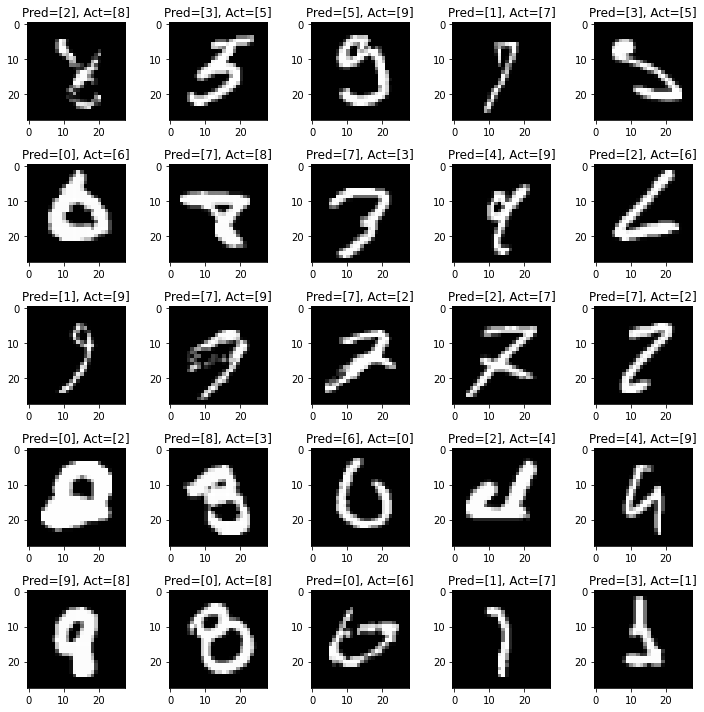

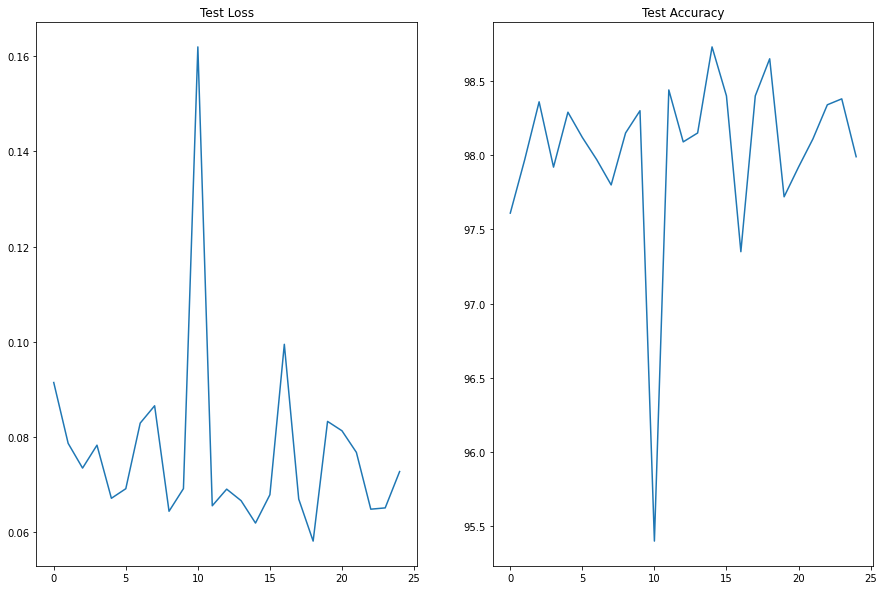

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    gbn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1L2_Loss, gbn_test_with_L1L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.17892926931381226 Batch_id=1874 Accuracy=88.50: 100%|██████████| 1875/1875 [00:24<00:00, 75.64it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  198

Test set: Average loss: 0.0622, Accuracy: 9802/10000 (98.02%)

EPOCH: 2


Train Set: Train Loss=0.05169661343097687 Batch_id=1874 Accuracy=95.85: 100%|██████████| 1875/1875 [00:24<00:00, 76.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  114

Test set: Average loss: 0.0367, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Train Set: Train Loss=0.025266140699386597 Batch_id=1874 Accuracy=96.59: 100%|██████████| 1875/1875 [00:25<00:00, 74.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  109

Test set: Average loss: 0.0325, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Train Set: Train Loss=0.08139428496360779 Batch_id=1874 Accuracy=96.93: 100%|██████████| 1875/1875 [00:24<00:00, 77.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  99

Test set: Average loss: 0.0305, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Train Set: Train Loss=0.026720404624938965 Batch_id=1874 Accuracy=97.29: 100%|██████████| 1875/1875 [00:25<00:00, 74.60it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  84

Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Train Set: Train Loss=0.017596706748008728 Batch_id=1874 Accuracy=97.52: 100%|██████████| 1875/1875 [00:24<00:00, 75.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  89

Test set: Average loss: 0.0287, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Train Set: Train Loss=0.08678671717643738 Batch_id=1874 Accuracy=97.52: 100%|██████████| 1875/1875 [00:24<00:00, 75.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  84

Test set: Average loss: 0.0285, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Train Set: Train Loss=0.14366917312145233 Batch_id=1874 Accuracy=97.54: 100%|██████████| 1875/1875 [00:24<00:00, 76.26it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  80

Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Train Set: Train Loss=0.1106831282377243 Batch_id=1874 Accuracy=97.77: 100%|██████████| 1875/1875 [00:24<00:00, 75.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  79

Test set: Average loss: 0.0257, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Train Set: Train Loss=0.024194955825805664 Batch_id=1874 Accuracy=97.80: 100%|██████████| 1875/1875 [00:24<00:00, 76.22it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Train Set: Train Loss=0.00897371768951416 Batch_id=1874 Accuracy=97.80: 100%|██████████| 1875/1875 [00:24<00:00, 76.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  94

Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Train Set: Train Loss=0.01810431480407715 Batch_id=1874 Accuracy=97.97: 100%|██████████| 1875/1875 [00:24<00:00, 76.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  77

Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Train Set: Train Loss=0.02230125665664673 Batch_id=1874 Accuracy=97.95: 100%|██████████| 1875/1875 [00:24<00:00, 75.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  73

Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Train Set: Train Loss=0.0302763432264328 Batch_id=1874 Accuracy=98.08: 100%|██████████| 1875/1875 [00:24<00:00, 76.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Train Set: Train Loss=0.012437373399734497 Batch_id=1874 Accuracy=98.06: 100%|██████████| 1875/1875 [00:25<00:00, 74.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  70

Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Train Set: Train Loss=0.008758559823036194 Batch_id=1874 Accuracy=97.98: 100%|██████████| 1875/1875 [00:24<00:00, 75.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Train Set: Train Loss=0.00889788568019867 Batch_id=1874 Accuracy=98.11: 100%|██████████| 1875/1875 [00:24<00:00, 75.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0222, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Train Set: Train Loss=0.059641674160957336 Batch_id=1874 Accuracy=98.12: 100%|██████████| 1875/1875 [00:24<00:00, 76.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0214, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Train Set: Train Loss=0.0017994940280914307 Batch_id=1874 Accuracy=98.17: 100%|██████████| 1875/1875 [00:24<00:00, 75.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Train Set: Train Loss=0.022609785199165344 Batch_id=1874 Accuracy=98.13: 100%|██████████| 1875/1875 [00:25<00:00, 74.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Train Set: Train Loss=0.03474953770637512 Batch_id=1874 Accuracy=98.21: 100%|██████████| 1875/1875 [00:24<00:00, 76.99it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Train Set: Train Loss=0.22683052718639374 Batch_id=1874 Accuracy=98.25: 100%|██████████| 1875/1875 [00:24<00:00, 75.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  69

Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Train Set: Train Loss=0.010726243257522583 Batch_id=1874 Accuracy=98.27: 100%|██████████| 1875/1875 [00:24<00:00, 75.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Train Set: Train Loss=0.008651316165924072 Batch_id=1874 Accuracy=98.24: 100%|██████████| 1875/1875 [00:24<00:00, 76.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  71

Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 25


Train Set: Train Loss=0.003921210765838623 Batch_id=1874 Accuracy=98.24: 100%|██████████| 1875/1875 [00:24<00:00, 75.04it/s]


Number of miscalssified Images =  60

Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)



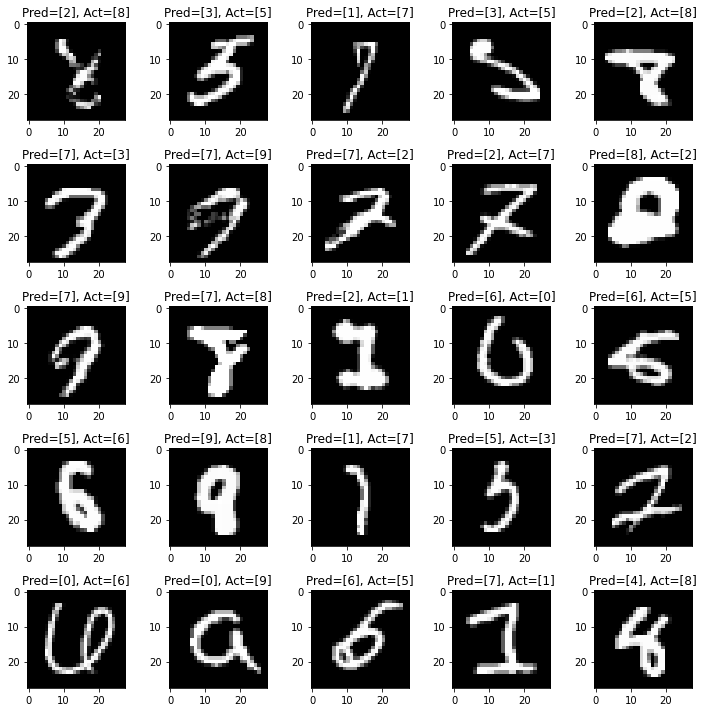

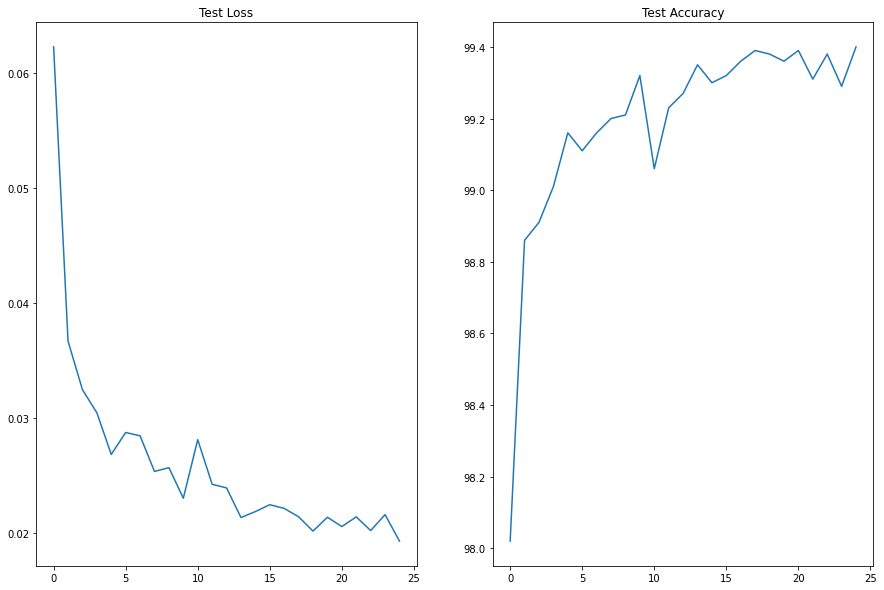

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE)

    bn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_without_L1L2_Loss, bn_test_without_L1L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.14172226190567017 Batch_id=1874 Accuracy=88.18: 100%|██████████| 1875/1875 [00:25<00:00, 72.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  166

Test set: Average loss: 0.0689, Accuracy: 9834/10000 (98.34%)

EPOCH: 2


Train Set: Train Loss=0.19977177679538727 Batch_id=1874 Accuracy=94.74: 100%|██████████| 1875/1875 [00:25<00:00, 74.74it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  169

Test set: Average loss: 0.0687, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Train Set: Train Loss=0.10274941474199295 Batch_id=1874 Accuracy=95.35: 100%|██████████| 1875/1875 [00:25<00:00, 73.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  186

Test set: Average loss: 0.0721, Accuracy: 9814/10000 (98.14%)

EPOCH: 4


Train Set: Train Loss=0.24754099547863007 Batch_id=1874 Accuracy=95.39: 100%|██████████| 1875/1875 [00:25<00:00, 74.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  209

Test set: Average loss: 0.0840, Accuracy: 9791/10000 (97.91%)

EPOCH: 5


Train Set: Train Loss=0.11755657941102982 Batch_id=1874 Accuracy=95.57: 100%|██████████| 1875/1875 [00:25<00:00, 74.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  181

Test set: Average loss: 0.0692, Accuracy: 9819/10000 (98.19%)

EPOCH: 6


Train Set: Train Loss=0.09431709349155426 Batch_id=1874 Accuracy=95.75: 100%|██████████| 1875/1875 [00:25<00:00, 73.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  174

Test set: Average loss: 0.0705, Accuracy: 9826/10000 (98.26%)

EPOCH: 7


Train Set: Train Loss=0.28431937098503113 Batch_id=1874 Accuracy=95.71: 100%|██████████| 1875/1875 [00:25<00:00, 74.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  129

Test set: Average loss: 0.0547, Accuracy: 9871/10000 (98.71%)

EPOCH: 8


Train Set: Train Loss=0.1183386892080307 Batch_id=1874 Accuracy=95.69: 100%|██████████| 1875/1875 [00:25<00:00, 73.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  177

Test set: Average loss: 0.0737, Accuracy: 9823/10000 (98.23%)

EPOCH: 9


Train Set: Train Loss=0.21308401226997375 Batch_id=1874 Accuracy=95.82: 100%|██████████| 1875/1875 [00:25<00:00, 73.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0681, Accuracy: 9816/10000 (98.16%)

EPOCH: 10


Train Set: Train Loss=0.13749782741069794 Batch_id=1874 Accuracy=95.91: 100%|██████████| 1875/1875 [00:24<00:00, 75.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  174

Test set: Average loss: 0.0706, Accuracy: 9826/10000 (98.26%)

EPOCH: 11


Train Set: Train Loss=0.07906867563724518 Batch_id=1874 Accuracy=95.73: 100%|██████████| 1875/1875 [00:25<00:00, 74.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  142

Test set: Average loss: 0.0547, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Train Set: Train Loss=0.1359279453754425 Batch_id=1874 Accuracy=95.76: 100%|██████████| 1875/1875 [00:25<00:00, 73.99it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  149

Test set: Average loss: 0.0548, Accuracy: 9851/10000 (98.51%)

EPOCH: 13


Train Set: Train Loss=0.19490808248519897 Batch_id=1874 Accuracy=95.85: 100%|██████████| 1875/1875 [00:25<00:00, 73.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  213

Test set: Average loss: 0.0749, Accuracy: 9787/10000 (97.87%)

EPOCH: 14


Train Set: Train Loss=0.3097618818283081 Batch_id=1874 Accuracy=95.82: 100%|██████████| 1875/1875 [00:25<00:00, 73.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  241

Test set: Average loss: 0.0910, Accuracy: 9759/10000 (97.59%)

EPOCH: 15


Train Set: Train Loss=0.19614730775356293 Batch_id=1874 Accuracy=95.71: 100%|██████████| 1875/1875 [00:25<00:00, 73.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  171

Test set: Average loss: 0.0669, Accuracy: 9829/10000 (98.29%)

EPOCH: 16


Train Set: Train Loss=0.15402927994728088 Batch_id=1874 Accuracy=95.89: 100%|██████████| 1875/1875 [00:24<00:00, 75.04it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0532, Accuracy: 9870/10000 (98.70%)

EPOCH: 17


Train Set: Train Loss=0.1125059649348259 Batch_id=1874 Accuracy=95.64: 100%|██████████| 1875/1875 [00:26<00:00, 72.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0630, Accuracy: 9859/10000 (98.59%)

EPOCH: 18


Train Set: Train Loss=0.16230982542037964 Batch_id=1874 Accuracy=95.83: 100%|██████████| 1875/1875 [00:25<00:00, 73.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  179

Test set: Average loss: 0.0712, Accuracy: 9821/10000 (98.21%)

EPOCH: 19


Train Set: Train Loss=0.12690262496471405 Batch_id=1874 Accuracy=95.78: 100%|██████████| 1875/1875 [00:24<00:00, 75.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0614, Accuracy: 9859/10000 (98.59%)

EPOCH: 20


Train Set: Train Loss=0.11275067925453186 Batch_id=1874 Accuracy=95.79: 100%|██████████| 1875/1875 [00:25<00:00, 73.31it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  145

Test set: Average loss: 0.0568, Accuracy: 9855/10000 (98.55%)

EPOCH: 21


Train Set: Train Loss=0.2991107702255249 Batch_id=1874 Accuracy=95.81: 100%|██████████| 1875/1875 [00:25<00:00, 72.92it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  168

Test set: Average loss: 0.0622, Accuracy: 9832/10000 (98.32%)

EPOCH: 22


Train Set: Train Loss=0.19071964919567108 Batch_id=1874 Accuracy=95.75: 100%|██████████| 1875/1875 [00:24<00:00, 75.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  312

Test set: Average loss: 0.1073, Accuracy: 9688/10000 (96.88%)

EPOCH: 23


Train Set: Train Loss=0.10555203258991241 Batch_id=1874 Accuracy=95.97: 100%|██████████| 1875/1875 [00:25<00:00, 73.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  139

Test set: Average loss: 0.0563, Accuracy: 9861/10000 (98.61%)

EPOCH: 24


Train Set: Train Loss=0.14295022189617157 Batch_id=1874 Accuracy=95.94: 100%|██████████| 1875/1875 [00:25<00:00, 73.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  157

Test set: Average loss: 0.0551, Accuracy: 9843/10000 (98.43%)

EPOCH: 25


Train Set: Train Loss=0.13179665803909302 Batch_id=1874 Accuracy=95.80: 100%|██████████| 1875/1875 [00:24<00:00, 75.61it/s]


Number of miscalssified Images =  173

Test set: Average loss: 0.0649, Accuracy: 9827/10000 (98.27%)



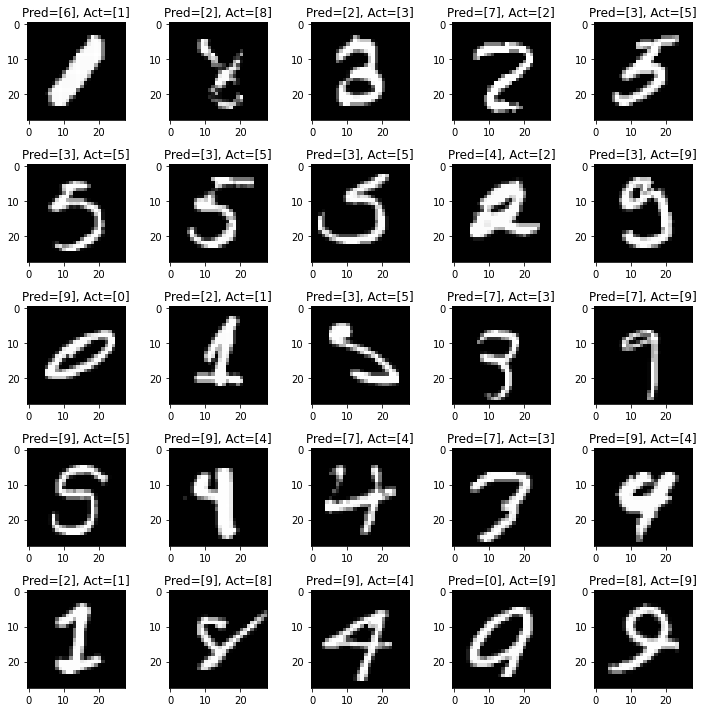

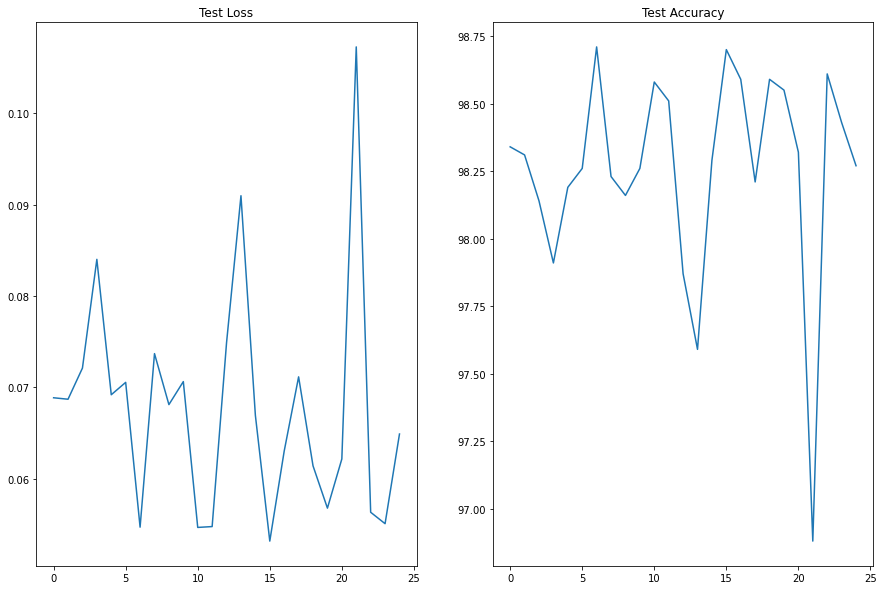

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, optimizer=l2_regulizer)

    bn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL2)

    bn_test_with_L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L2_Loss, bn_test_with_L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.4560823440551758 Batch_id=1874 Accuracy=88.24: 100%|██████████| 1875/1875 [00:28<00:00, 64.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  201

Test set: Average loss: 0.0633, Accuracy: 9799/10000 (97.99%)

EPOCH: 2


Train Set: Train Loss=0.48300474882125854 Batch_id=1874 Accuracy=94.98: 100%|██████████| 1875/1875 [00:29<00:00, 63.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  183

Test set: Average loss: 0.0639, Accuracy: 9817/10000 (98.17%)

EPOCH: 3


Train Set: Train Loss=0.30396658182144165 Batch_id=1874 Accuracy=95.42: 100%|██████████| 1875/1875 [00:29<00:00, 64.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  157

Test set: Average loss: 0.0499, Accuracy: 9843/10000 (98.43%)

EPOCH: 4


Train Set: Train Loss=0.3178941607475281 Batch_id=1874 Accuracy=95.62: 100%|██████████| 1875/1875 [00:28<00:00, 65.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  151

Test set: Average loss: 0.0442, Accuracy: 9849/10000 (98.49%)

EPOCH: 5


Train Set: Train Loss=0.4250882863998413 Batch_id=1874 Accuracy=95.79: 100%|██████████| 1875/1875 [00:28<00:00, 66.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  174

Test set: Average loss: 0.0574, Accuracy: 9826/10000 (98.26%)

EPOCH: 6


Train Set: Train Loss=0.29293161630630493 Batch_id=1874 Accuracy=95.90: 100%|██████████| 1875/1875 [00:28<00:00, 64.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  189

Test set: Average loss: 0.0584, Accuracy: 9811/10000 (98.11%)

EPOCH: 7


Train Set: Train Loss=0.5448310375213623 Batch_id=1874 Accuracy=95.99: 100%|██████████| 1875/1875 [00:28<00:00, 66.03it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  177

Test set: Average loss: 0.0572, Accuracy: 9823/10000 (98.23%)

EPOCH: 8


Train Set: Train Loss=0.40279048681259155 Batch_id=1874 Accuracy=95.85: 100%|██████████| 1875/1875 [00:28<00:00, 64.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  163

Test set: Average loss: 0.0503, Accuracy: 9837/10000 (98.37%)

EPOCH: 9


Train Set: Train Loss=0.36292898654937744 Batch_id=1874 Accuracy=96.11: 100%|██████████| 1875/1875 [00:28<00:00, 65.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  161

Test set: Average loss: 0.0490, Accuracy: 9839/10000 (98.39%)

EPOCH: 10


Train Set: Train Loss=0.4647454023361206 Batch_id=1874 Accuracy=96.09: 100%|██████████| 1875/1875 [00:28<00:00, 65.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  154

Test set: Average loss: 0.0543, Accuracy: 9846/10000 (98.46%)

EPOCH: 11


Train Set: Train Loss=0.2930030822753906 Batch_id=1874 Accuracy=96.09: 100%|██████████| 1875/1875 [00:28<00:00, 66.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0429, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Train Set: Train Loss=0.40769970417022705 Batch_id=1874 Accuracy=96.16: 100%|██████████| 1875/1875 [00:28<00:00, 65.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  140

Test set: Average loss: 0.0440, Accuracy: 9860/10000 (98.60%)

EPOCH: 13


Train Set: Train Loss=0.3107949495315552 Batch_id=1874 Accuracy=96.17: 100%|██████████| 1875/1875 [00:29<00:00, 63.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  140

Test set: Average loss: 0.0446, Accuracy: 9860/10000 (98.60%)

EPOCH: 14


Train Set: Train Loss=0.5317495465278625 Batch_id=1874 Accuracy=96.02: 100%|██████████| 1875/1875 [00:28<00:00, 64.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  167

Test set: Average loss: 0.0494, Accuracy: 9833/10000 (98.33%)

EPOCH: 15


Train Set: Train Loss=0.44856205582618713 Batch_id=1874 Accuracy=96.01: 100%|██████████| 1875/1875 [00:28<00:00, 65.12it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0406, Accuracy: 9870/10000 (98.70%)

EPOCH: 16


Train Set: Train Loss=0.3978326916694641 Batch_id=1874 Accuracy=96.07: 100%|██████████| 1875/1875 [00:29<00:00, 64.26it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  164

Test set: Average loss: 0.0499, Accuracy: 9836/10000 (98.36%)

EPOCH: 17


Train Set: Train Loss=0.2781207859516144 Batch_id=1874 Accuracy=96.13: 100%|██████████| 1875/1875 [00:28<00:00, 65.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  145

Test set: Average loss: 0.0465, Accuracy: 9855/10000 (98.55%)

EPOCH: 18


Train Set: Train Loss=0.3840433955192566 Batch_id=1874 Accuracy=96.04: 100%|██████████| 1875/1875 [00:28<00:00, 64.83it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  151

Test set: Average loss: 0.0460, Accuracy: 9849/10000 (98.49%)

EPOCH: 19


Train Set: Train Loss=0.2939797341823578 Batch_id=1874 Accuracy=96.23: 100%|██████████| 1875/1875 [00:28<00:00, 65.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  187

Test set: Average loss: 0.0562, Accuracy: 9813/10000 (98.13%)

EPOCH: 20


Train Set: Train Loss=0.2892512083053589 Batch_id=1874 Accuracy=96.05: 100%|██████████| 1875/1875 [00:29<00:00, 64.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  151

Test set: Average loss: 0.0446, Accuracy: 9849/10000 (98.49%)

EPOCH: 21


Train Set: Train Loss=0.3428482413291931 Batch_id=1874 Accuracy=96.08: 100%|██████████| 1875/1875 [00:29<00:00, 64.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0434, Accuracy: 9859/10000 (98.59%)

EPOCH: 22


Train Set: Train Loss=0.36516880989074707 Batch_id=1874 Accuracy=96.13: 100%|██████████| 1875/1875 [00:28<00:00, 64.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  126

Test set: Average loss: 0.0391, Accuracy: 9874/10000 (98.74%)

EPOCH: 23


Train Set: Train Loss=0.29344308376312256 Batch_id=1874 Accuracy=96.17: 100%|██████████| 1875/1875 [00:29<00:00, 64.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0459, Accuracy: 9862/10000 (98.62%)

EPOCH: 24


Train Set: Train Loss=0.3943992853164673 Batch_id=1874 Accuracy=96.13: 100%|██████████| 1875/1875 [00:28<00:00, 65.60it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  149

Test set: Average loss: 0.0462, Accuracy: 9851/10000 (98.51%)

EPOCH: 25


Train Set: Train Loss=0.3327750563621521 Batch_id=1874 Accuracy=96.03: 100%|██████████| 1875/1875 [00:28<00:00, 64.90it/s]


Number of miscalssified Images =  144

Test set: Average loss: 0.0441, Accuracy: 9856/10000 (98.56%)



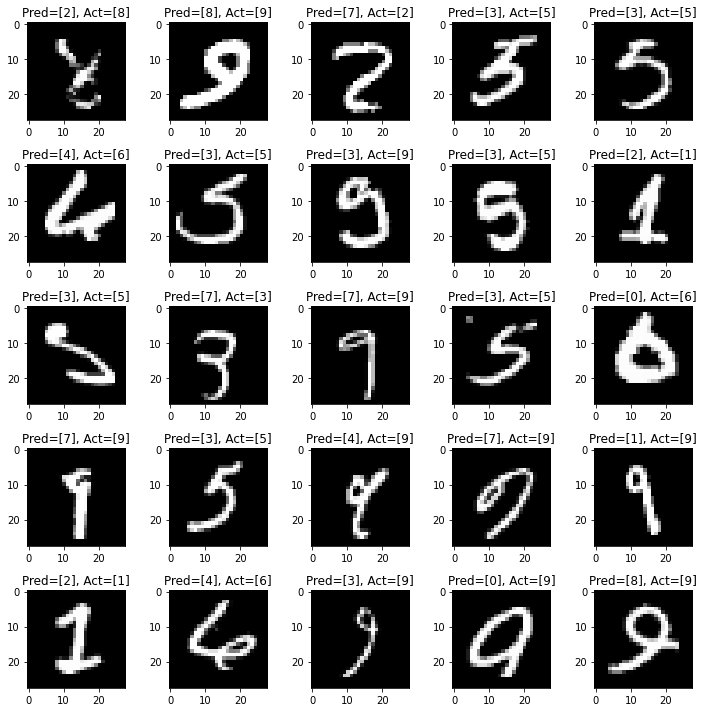

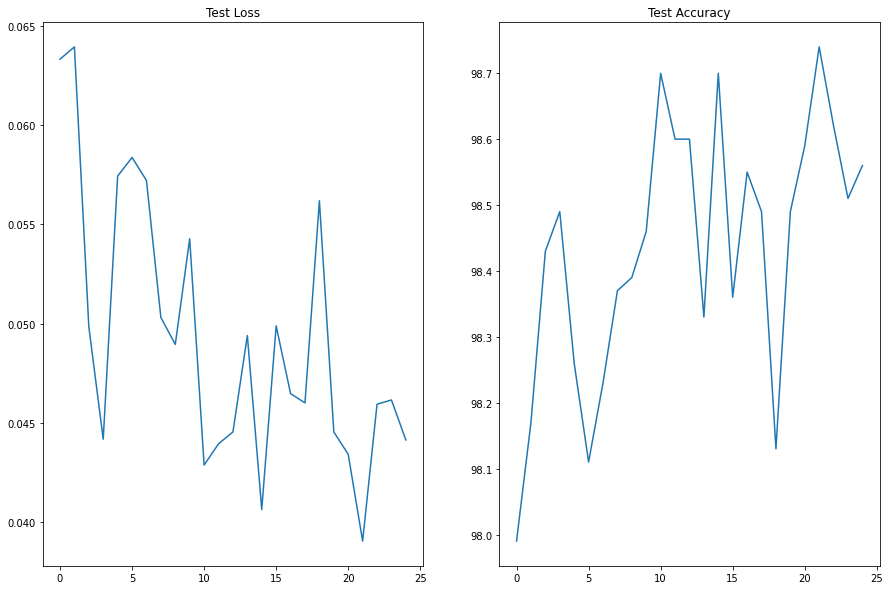

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005)

    bn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL1)

    bn_test_with_L1_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1_Loss, bn_test_with_L1_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.5100816488265991 Batch_id=1874 Accuracy=87.67: 100%|██████████| 1875/1875 [00:30<00:00, 61.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  322

Test set: Average loss: 0.1266, Accuracy: 9678/10000 (96.78%)

EPOCH: 2


Train Set: Train Loss=0.47008898854255676 Batch_id=1874 Accuracy=93.53: 100%|██████████| 1875/1875 [00:29<00:00, 64.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  227

Test set: Average loss: 0.0974, Accuracy: 9773/10000 (97.73%)

EPOCH: 3


Train Set: Train Loss=0.35609498620033264 Batch_id=1874 Accuracy=94.00: 100%|██████████| 1875/1875 [00:29<00:00, 63.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  214

Test set: Average loss: 0.0870, Accuracy: 9786/10000 (97.86%)

EPOCH: 4


Train Set: Train Loss=0.2817551791667938 Batch_id=1874 Accuracy=94.08: 100%|██████████| 1875/1875 [00:29<00:00, 63.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  232

Test set: Average loss: 0.0935, Accuracy: 9768/10000 (97.68%)

EPOCH: 5


Train Set: Train Loss=0.42603522539138794 Batch_id=1874 Accuracy=94.27: 100%|██████████| 1875/1875 [00:29<00:00, 63.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  306

Test set: Average loss: 0.1184, Accuracy: 9694/10000 (96.94%)

EPOCH: 6


Train Set: Train Loss=0.40754610300064087 Batch_id=1874 Accuracy=94.34: 100%|██████████| 1875/1875 [00:29<00:00, 64.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  343

Test set: Average loss: 0.1254, Accuracy: 9657/10000 (96.57%)

EPOCH: 7


Train Set: Train Loss=0.5823785066604614 Batch_id=1874 Accuracy=94.38: 100%|██████████| 1875/1875 [00:29<00:00, 64.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  206

Test set: Average loss: 0.0889, Accuracy: 9794/10000 (97.94%)

EPOCH: 8


Train Set: Train Loss=0.40232640504837036 Batch_id=1874 Accuracy=94.31: 100%|██████████| 1875/1875 [00:29<00:00, 63.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  251

Test set: Average loss: 0.0895, Accuracy: 9749/10000 (97.49%)

EPOCH: 9


Train Set: Train Loss=0.5772655010223389 Batch_id=1874 Accuracy=94.31: 100%|██████████| 1875/1875 [00:29<00:00, 64.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  178

Test set: Average loss: 0.0745, Accuracy: 9822/10000 (98.22%)

EPOCH: 10


Train Set: Train Loss=0.49704837799072266 Batch_id=1874 Accuracy=94.35: 100%|██████████| 1875/1875 [00:29<00:00, 63.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  421

Test set: Average loss: 0.1576, Accuracy: 9579/10000 (95.79%)

EPOCH: 11


Train Set: Train Loss=0.33681344985961914 Batch_id=1874 Accuracy=94.47: 100%|██████████| 1875/1875 [00:29<00:00, 64.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  324

Test set: Average loss: 0.1234, Accuracy: 9676/10000 (96.76%)

EPOCH: 12


Train Set: Train Loss=0.3440820872783661 Batch_id=1874 Accuracy=94.48: 100%|██████████| 1875/1875 [00:29<00:00, 64.04it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  197

Test set: Average loss: 0.0822, Accuracy: 9803/10000 (98.03%)

EPOCH: 13


Train Set: Train Loss=0.44667887687683105 Batch_id=1874 Accuracy=94.45: 100%|██████████| 1875/1875 [00:29<00:00, 63.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  195

Test set: Average loss: 0.0856, Accuracy: 9805/10000 (98.05%)

EPOCH: 14


Train Set: Train Loss=0.5586501955986023 Batch_id=1874 Accuracy=94.50: 100%|██████████| 1875/1875 [00:29<00:00, 63.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  231

Test set: Average loss: 0.0932, Accuracy: 9769/10000 (97.69%)

EPOCH: 15


Train Set: Train Loss=0.3906705677509308 Batch_id=1874 Accuracy=94.28: 100%|██████████| 1875/1875 [00:29<00:00, 63.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  304

Test set: Average loss: 0.1174, Accuracy: 9696/10000 (96.96%)

EPOCH: 16


Train Set: Train Loss=0.375759094953537 Batch_id=1874 Accuracy=94.44: 100%|██████████| 1875/1875 [00:29<00:00, 62.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  171

Test set: Average loss: 0.0673, Accuracy: 9829/10000 (98.29%)

EPOCH: 17


Train Set: Train Loss=0.35598745942115784 Batch_id=1874 Accuracy=94.38: 100%|██████████| 1875/1875 [00:28<00:00, 65.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  216

Test set: Average loss: 0.0838, Accuracy: 9784/10000 (97.84%)

EPOCH: 18


Train Set: Train Loss=0.3336198925971985 Batch_id=1874 Accuracy=94.46: 100%|██████████| 1875/1875 [00:30<00:00, 61.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  232

Test set: Average loss: 0.0922, Accuracy: 9768/10000 (97.68%)

EPOCH: 19


Train Set: Train Loss=0.42158088088035583 Batch_id=1874 Accuracy=94.25: 100%|██████████| 1875/1875 [00:28<00:00, 65.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  170

Test set: Average loss: 0.0714, Accuracy: 9830/10000 (98.30%)

EPOCH: 20


Train Set: Train Loss=0.35961413383483887 Batch_id=1874 Accuracy=94.40: 100%|██████████| 1875/1875 [00:29<00:00, 64.43it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  227

Test set: Average loss: 0.0855, Accuracy: 9773/10000 (97.73%)

EPOCH: 21


Train Set: Train Loss=0.5798543691635132 Batch_id=1874 Accuracy=94.42: 100%|██████████| 1875/1875 [00:28<00:00, 65.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  255

Test set: Average loss: 0.0954, Accuracy: 9745/10000 (97.45%)

EPOCH: 22


Train Set: Train Loss=0.3875780701637268 Batch_id=1874 Accuracy=94.54: 100%|██████████| 1875/1875 [00:29<00:00, 64.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  320

Test set: Average loss: 0.1183, Accuracy: 9680/10000 (96.80%)

EPOCH: 23


Train Set: Train Loss=0.31108006834983826 Batch_id=1874 Accuracy=94.37: 100%|██████████| 1875/1875 [00:30<00:00, 62.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  197

Test set: Average loss: 0.0775, Accuracy: 9803/10000 (98.03%)

EPOCH: 24


Train Set: Train Loss=0.45158249139785767 Batch_id=1874 Accuracy=94.34: 100%|██████████| 1875/1875 [00:29<00:00, 62.86it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  232

Test set: Average loss: 0.0881, Accuracy: 9768/10000 (97.68%)

EPOCH: 25


Train Set: Train Loss=0.3209720253944397 Batch_id=1874 Accuracy=94.38: 100%|██████████| 1875/1875 [00:29<00:00, 64.36it/s]


Number of miscalssified Images =  235

Test set: Average loss: 0.0952, Accuracy: 9765/10000 (97.65%)



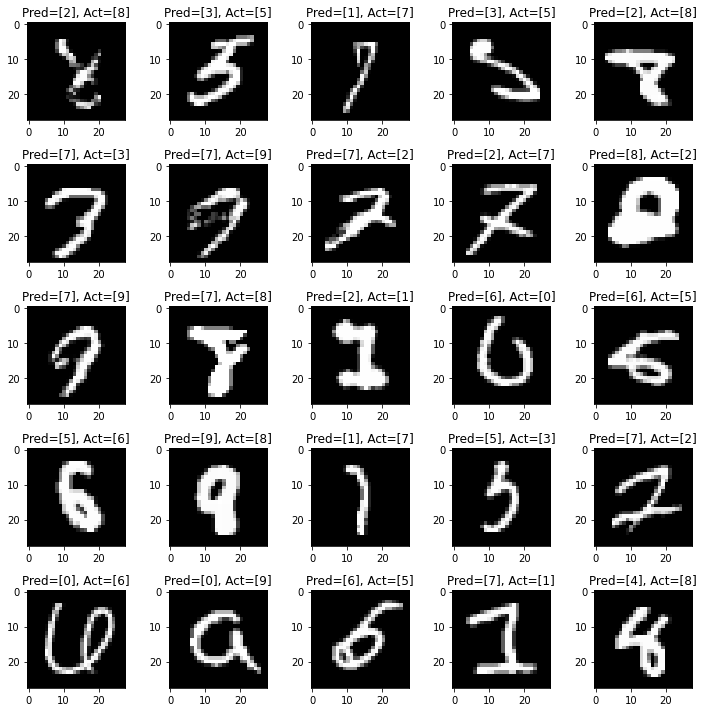

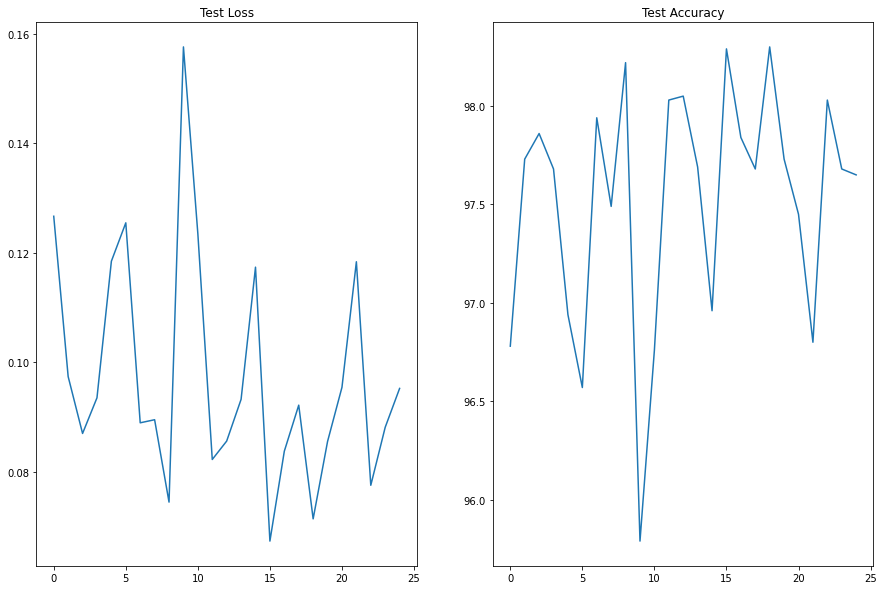

In [0]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    bn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1L2_Loss, bn_test_with_L1L2_acc)

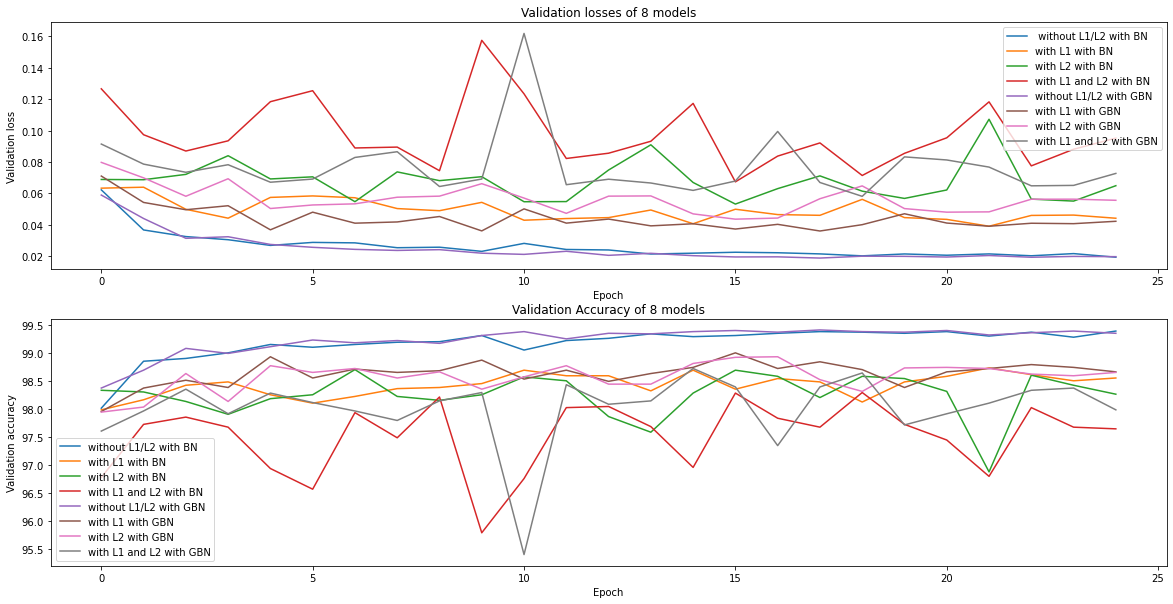

In [0]:

fig, axs = plt.subplots(2,1, figsize=(20,10))
axs[0].plot(bn_test_without_L1L2_Loss, label=' without L1/L2 with BN')
axs[0].plot(bn_test_with_L1_Loss, label='with L1 with BN')
axs[0].plot(bn_test_with_L2_Loss, label='with L2 with BN')
axs[0].plot(bn_test_with_L1L2_Loss, label='with L1 and L2 with BN')

axs[0].plot(gbn_test_without_L1L2_Loss, label='without L1/L2 with GBN')
axs[0].plot(gbn_test_with_L1_Loss, label='with L1 with GBN')
axs[0].plot(gbn_test_with_L2_Loss, label='with L2 with GBN')
axs[0].plot(gbn_test_with_L1L2_Loss, label='with L1 and L2 with GBN')

axs[0].set(title="Validation losses of 8 models", xlabel="Epoch", ylabel="Validation loss")


axs[0].legend(loc='best')

axs[1].plot(bn_test_without_L1L2_acc, label='without L1/L2 with BN')
axs[1].plot(bn_test_with_L1_acc, label='with L1 with BN')
axs[1].plot(bn_test_with_L2_acc, label='with L2 with BN')
axs[1].plot(bn_test_with_L1L2_acc, label='with L1 and L2 with BN')

axs[1].plot(gbn_test_without_L1L2_acc, label='without L1/L2 with GBN')
axs[1].plot(gbn_test_with_L1_acc, label='with L1 with GBN')
axs[1].plot(gbn_test_with_L2_acc, label='with L2 with GBN')
axs[1].plot(gbn_test_with_L1L2_acc, label='with L1 and L2 with GBN')

axs[1].set(title="Validation Accuracy of 8 models", xlabel="Epoch", ylabel="Validation accuracy")
axs[1].legend(loc='best')